# ASTR 596: FDS Homework 6+7: Gaussian Processes (200 pts)

### This is a double HW set so you get extra time - until reading day (May 4th, 2023) at noon to do it. 
### After that, it's finals time. 


# P1. Gaussian Processes

### Last HW, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [4]:
%matplotlib notebook
%pylab

from astropy.table import Table
import scipy.stats as st
import sklearn
import sklearn.ensemble

Using matplotlib backend: nbAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

In [ ]:
qs = sorted(np.unique(tab['quarter']))
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False);


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations. (20 pts)

In [ ]:
#Using as drop

### Q2: To implement the full model, read how to use `george`'s modeling protocol: (20 pts)
https://george.readthedocs.io/en/latest/tutorials/model/

In [ ]:
#Using as drop

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots) (20 pts)

In [ ]:
#Using as drop

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps) (20 pts)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help 

In [ ]:
#Using as drop

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black.  (20 pts)

In [ ]:
#Using as drop

# P2. Random Forests

For this work, we'll use the datasets produced by [Dey et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.515.5285D/abstract), who trained a deep capsule network on postage stamps of SDSS galaxies to predict photometric redshifts. 

We're not going to use a deep capsule network on postage stamps, but we can use tabular data. This won't be as performant, but it's still instructive to see how well we can do with a simple random forest. Dey et al. have done an excellent job making their data available - http://d-scholarship.pitt.edu/42023/ (all of it)

You will need the [training set](http://d-scholarship.pitt.edu/42023/9/cat_train.csv) and the [test set](http://d-scholarship.pitt.edu/42023/8/cat_test.csv).

I suggest reading through Sec. 2 of the paper to get some sense of what the data is. Importantly, the data includes columns for photometric redshift already. You can't use these to train your random forest (duh.). I've limited the number of columns you can use to a set defined below. If you use more than these (e.g. the GalaxyZoo parameters) you might get better performance at the cost of a smaller training sample because you've also got to filter missing data. 

In [1]:
train_cols = ['dered_petro_u', 'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',\
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i', 'petroMagErr_z',\
       'v_disp', 'sersicN_r', 'petroR90_r']
#had to remove bestObjID because it was messing with forest process
# i.e. had an oob score of -9 million...
pred_cols  = ['z', 'zErr', 'zphot', 'dzphot']

### Q6. Pre-process the data

All ML work involves some amount of cleaning and pre-processing the data.
Filter data that have `zphot_reliable` == `True`, and have redshifts and photo-zs >= 0. 
Next filter any entries in the `train_cols` that have any value that is > 5 $\times$ the nomrally-scaled Median Absolute Deviation (as described in Sec 2.3) (`scipy.stats.median_abs_deviation` is your friend). 
Your pre-processed training data should have 357397 entries.
Make a hexbin plot of `zphot` vs `z` for the training data (to avoid plotting that many points) but replicate Fig. 3 in Dey et al. 
(35 pts)

In [2]:
import pandas as pd
from astropy.io import ascii
import numpy as np
import scipy
import scipy.stats as st
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble

In [3]:
train_data = ascii.read('cat_train.csv', format='csv')
test_data = ascii.read('cat_test.csv',format='csv')

In [5]:
#filter zphot_reliable==True
mask_train = (train_data['zphot_reliable']==True) #&\
                            #(train_data['z'] >= 0) &\
                             #       (train_data['zphot'] >=0)
mask_test = (test_data['zphot_reliable']==True) #&\
                            #(test_data['z'] >= 0) &\
                             #       (test_data['zphot'] >=0)

In [6]:
test_data = test_data[mask_test]
train_data = train_data[mask_train]

In [7]:
def mad_filt(data,coloumn):
    mabdev = st.median_abs_deviation(data[column],scale = 'normal',nan_policy='omit')
    mabmask = (data[column] >= np.median(data[column])-5*mabdev) &\
                (data[column] <= np.median(data[column])+5*mabdev)
    return data[mabmask]

In [8]:
for column in train_cols:
    test_data = mad_filt(test_data,column)
    train_data = mad_filt(train_data,column)

/home/ctrim/anaconda3/envs/596/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


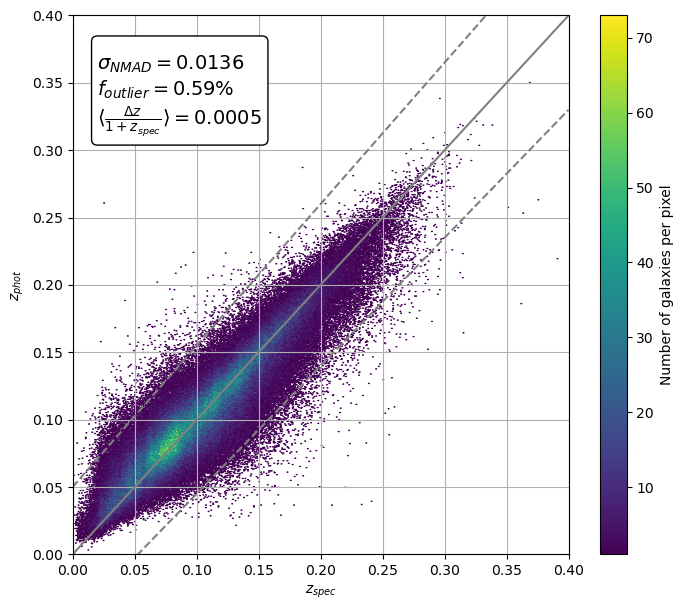

In [78]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
#gridsoze of 369 gives the same colorbar scaling as in Dey et al.
hexbin = ax.hexbin(train_data['z'], train_data['zphot'], mincnt=1,linewidths=.5, gridsize=(369,369))
cb = fig.colorbar(hexbin, label='Number of galaxies per pixel')
plt.xlabel(r'$z_{spec}$')
plt.ylabel(r'$z_{phot}$')

x = np.array([0, 0.4])
ax.plot(x, x, color='grey', linestyle='-')
ax.plot(x, (1.05 * x + 0.05), c='grey', linestyle='--')
ax.plot(x, (0.95 * x - 0.05), c='grey', linestyle='--')
ax.set_xlim(0, 0.4)
ax.set_ylim(0, 0.4)
ax.grid()


dz = (train_data['zphot']-train_data['z']) / (1 + train_data['z'])
avg_dz = np.abs(np.mean(dz)) #we only really care about this magnitude
sig_n = 1.4826*np.nanmedian(np.abs(dz-np.nanmedian(dz))) #as defined in section 5 of Dey et al.
f_outlier = (len(dz[dz > 0.05]) / len(dz))*100
#googled how to make a text box so this is copy paste from matplotlib's documentation
textstr = '\n'.join((
    '', #space needed to avoid values from clipping outside box
    r'$\sigma_{NMAD}=%.4f$' % (sig_n, ),
    r'$f_{outlier}=$'+'{:.2f}%'.format(f_outlier),
    r'$\langle\frac{\Delta z}{1+z_{spec}}\rangle=%.4f$' % (avg_dz, )))

box = dict(boxstyle='round', facecolor='white', alpha=1)

ax.text(0.05, 0.97, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=box)

plt.show(fig)

### Q7. Train the forest(s)

Using `n_estimators` (i.e. number of trees) in (5, 20, 50, 200, 500), train a random forest. You can use all the cores your CPU has with `n_jobs=-1`. Limit the maximum number of features at each branch with `sqrt`. Use the inverse variance of the redshifts as your sample weights. Plot the `oob_score` vs the number of trees. For each of the forests you trained, make a plot of the feature importances. (35 pts)

In [10]:
n_estimators = [5,20,50,200,500]
train_pd = train_data.to_pandas().dropna() #need to convert to pd due to issues with forest, and remove nans

boobs = [] #I'm sorry I had to...
f_importance = []
for n in n_estimators:
    forest = sklearn.ensemble.RandomForestRegressor(n_estimators=n, n_jobs=-1, max_features='sqrt', 
                                                 oob_score=True, random_state=42)
    x = train_pd[train_cols] 
    y = train_pd[pred_cols]#prediction
    weights = train_pd['zErr']**-2 #inverse variance
    forest.fit(x, y, weights)
    boobs.append(forest.oob_score_)
    f_importance.append(forest.feature_importances_)
    print('n_estimators =',n, 'completed')

/home/ctrim/anaconda3/envs/596/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n_estimators = 5 completed


/home/ctrim/anaconda3/envs/596/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n_estimators = 20 completed
n_estimators = 50 completed
n_estimators = 200 completed
n_estimators = 500 completed


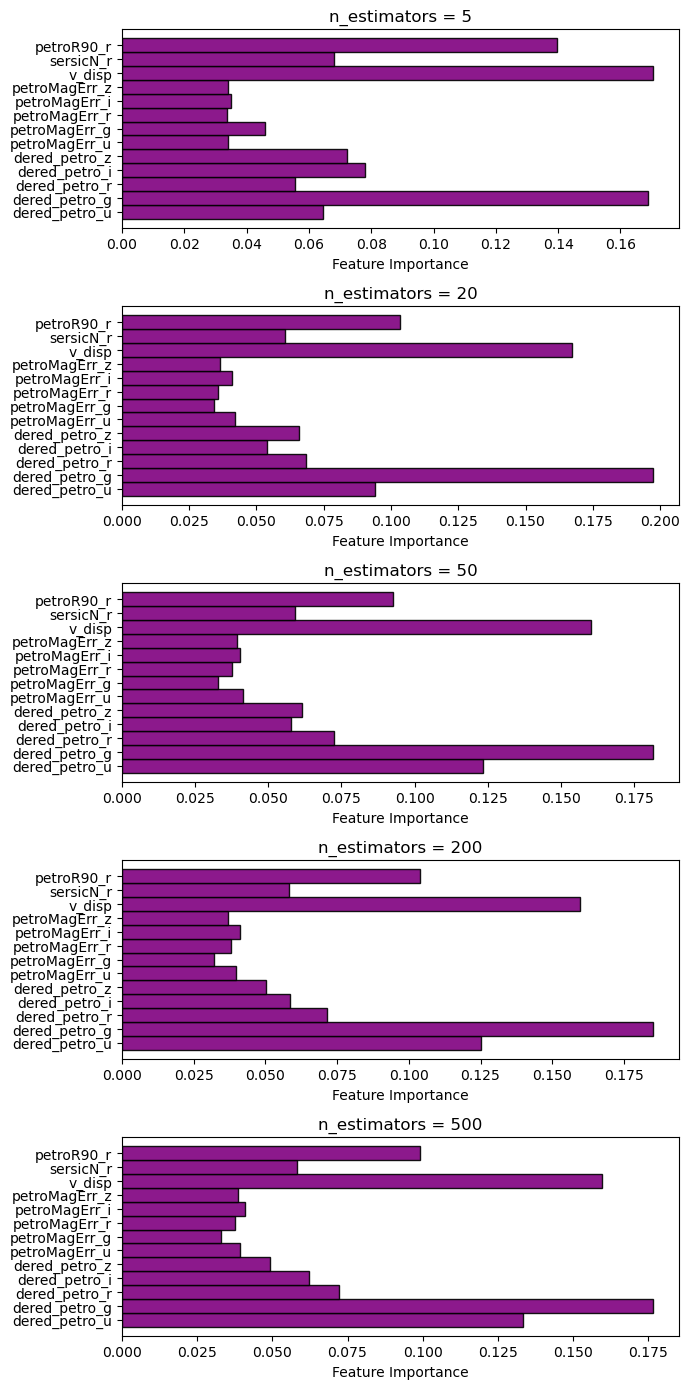

In [12]:
plt.figure(layout='tight',figsize=(7,14))
for i in range(len(n_estimators)):
    plt.subplot(511+i)
    plt.title(f'n_estimators = {n_estimators[i]}')
    plt.xlabel('Feature Importance')
    for j in range(len(train_cols)):
        plt.barh(train_cols[j],f_importance[i][j],height=1,color='purple',edgecolor = 'k',alpha=0.9)

Text(0.5, 0, '# of Branches')

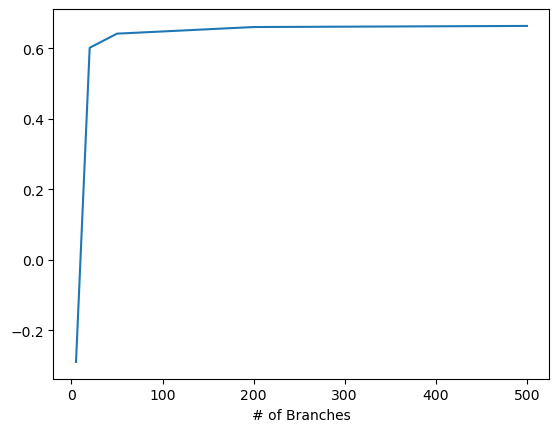

In [13]:
plt.plot(n_estimators,boobs)
plt.xlabel('# of Branches')

### Q8. Test.

Pick your best performing forest from Q7. Load the test data (remember to apply any cuts you did to the training data). Use your random forest to predict the photo-z. Replicate Fig. 3 and Fig. 4 with your photo-z prediction *and* the photo-z prediction from SDSS included in the file. (30 pts, 10 pts for prediction, 10 for the two figures)

In [52]:
#reconstruct best performing forest
best_nest = n_estimators[np.argmax(boobs)]
print(best_nest)
#for some reason the prediction step crashes my python kernel if I use n=500
# so I switched it to n=200 which works perfectly fine
best_forest= sklearn.ensemble.RandomForestRegressor(n_estimators=200, n_jobs=-1, max_features='sqrt', 
                                             oob_score=True, random_state=42)
x = train_pd[train_cols]
y = train_pd[pred_cols]
weight = train_pd['zErr'] ** -2
best_forest.fit(x, y, weight)

#predict the test data with best forest
test_pd = test_data.to_pandas().dropna()#again convert to pd to work with forest
x_test = test_pd[train_cols]
prediction = best_forest.predict(x_test)
pred_pd = pd.DataFrame(prediction, columns=pred_cols).dropna()

500


In [74]:
def silly_little_plotting_func(z, zphot, title):
    fig = plt.figure(figsize=(16,7))
    ax1 = fig.add_subplot(121)
    #gridsize of 369 gives the same colorbar scaling as in Dey et al.
    hexbin = ax1.hexbin(z, zphot, mincnt=1,linewidths=.5, gridsize=(369,369))
    cb = fig.colorbar(hexbin, label='Number of galaxies per pixel')
    ax1.set_xlabel(r'$z_{spec}$')
    ax1.set_ylabel(r'$z_{phot}$')
    

    x = np.array([0, 0.4])
    ax1.plot(x, x, color='grey', linestyle='-')
    ax1.plot(x, (1.05 * x + 0.05), c='grey', linestyle='--')
    ax1.plot(x, (0.95 * x - 0.05), c='grey', linestyle='--')
    ax1.set_xlim(0, 0.4)
    ax1.set_ylim(0, 0.4)
    ax1.grid()


    dz = (zphot-z) / (1 + z)
    avg_dz = np.abs(np.mean(dz)) #we only really care about this magnitude
    sig_n = 1.4826*st.median_abs_deviation(dz) #as defined in section 5 of Dey et al.
    sig_n2 = 1.4826*np.nanmedian(np.abs(dz-np.nanmedian(dz)))
    f_outlier = (len(dz[dz > 0.05]) / len(dz))*100
    #googled how to make a text box so this is kinda copy paste from matplotlib's documentation
    textstr = '\n'.join((
        '', #space needed to avoid values from clipping outside box
        r'$\sigma_{NMAD}=%.4f$' % (sig_n2, ),
        r'$f_{outlier}=$'+'{:.2f}%'.format(f_outlier),
        r'$\langle\frac{\Delta z}{1+z_{spec}}\rangle=%.4f$' % (avg_dz, )))

    box = dict(boxstyle='round', facecolor='white', alpha=1)

    ax1.text(0.05, 0.97, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=box)
    
    
    ax2 = fig.add_subplot(122)
    binsize = 0.1
    x2 = np.linspace(-binsize, binsize, 1000)
    n_dist = st.norm.pdf(x2, avg_dz, sig_n2)
    ax2.plot(x2, n_dist, color='orange')
    ax2.hist(dz, bins=60, density=True, color='lightblue')
    ax2.set_xlim(-binsize, binsize)
    ax2.grid(linestyle='--')
    ax2.set_xlabel(r'$\frac{\Delta z}{1+z_{spec}}$')
    ax2.set_ylabel(r'Relative Frequency')
    
    plt.suptitle(title)
    plt.show(fig)

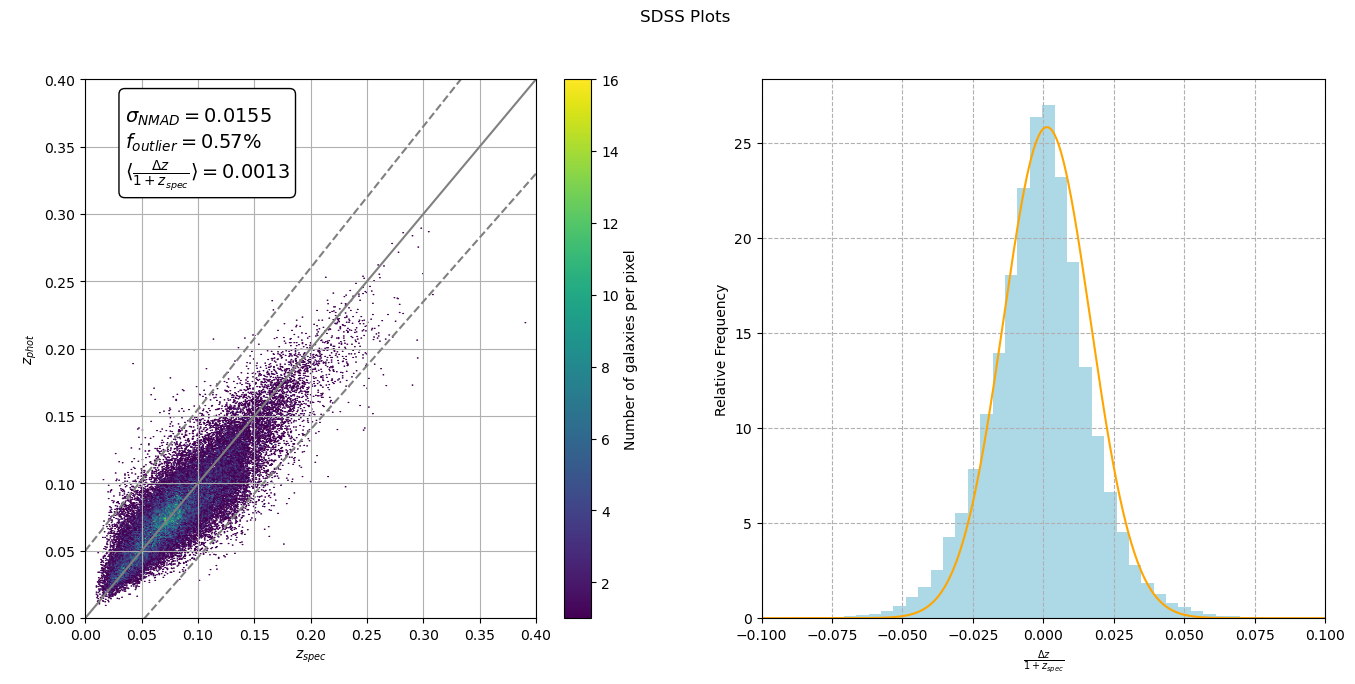

In [75]:
silly_little_plotting_func(train_pd['z'], train_pd['zphot'], 'SDSS Plots')

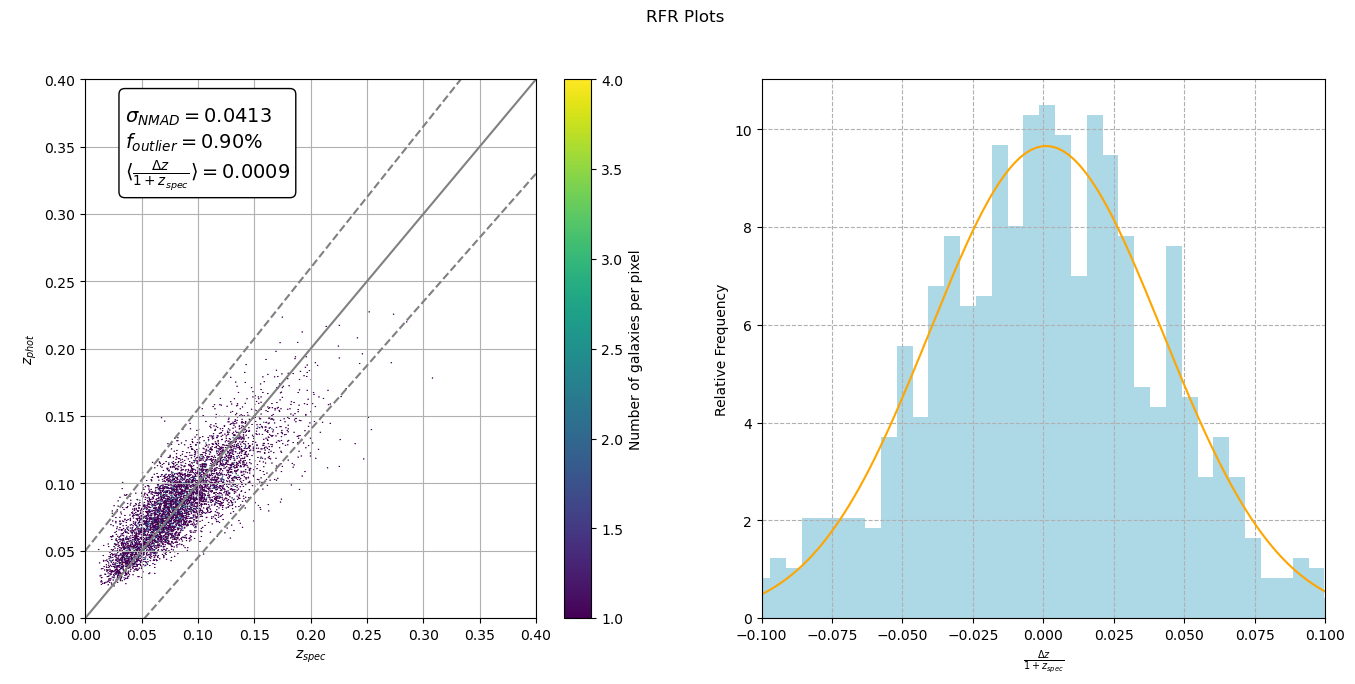

In [76]:
silly_little_plotting_func(test_pd['z'], pred_pd['z'], 'RFR Plots')